In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fft2, ifft2, fftfreq
from scipy.signal import find_peaks
import time

In [23]:
start = time.perf_counter()
# Parametry siatki
N = 2**9            # liczba punktów siatki - 1 w każdym kierunku
L = 40
x = np.linspace(-L/2, L/2, N)
dx = x[1] - x[0]         # krok przestrzenny

# Parametry fizyczne
ħ = 1.0
m = 1
ω = 1
dt = 0.008         # krok czasowy
Nt = 2**18
T_max = Nt * dt       # maksymalny czas
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")
T_max

Czas działania: 0.000304 sekundy


2097.152

In [24]:
start = time.perf_counter()

# Potencjał: V(x, y)
# Inicjalizacja potencjału oscylatora harmonicznego
V = 1/2 * m * ω * x**2

# Początkowa funkcja falowa — podwójna funkcja Gaussa
a1 = -0.5
sigma1 = 0.3
a2 = 0.8
sigma2 = 0.4
a3 = -2.0
sigma3 = 0.6
ψ = np.exp(-(x - a1)**2 / (2 * sigma1**2)) + np.exp(-(x - a2)**2 / (2 * sigma2**2)) + np.exp(-(x - a3)**2 / (2 * sigma3**2))
ψ /= np.linalg.norm(ψ)  # normalizacja

ψ0 = ψ.copy()  # zapisuję funkcję początkową do korelacji
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000373 sekundy


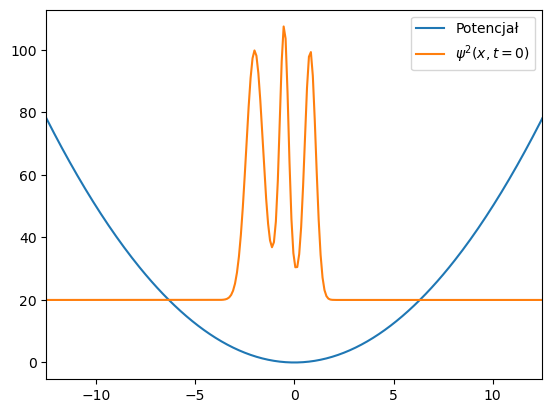

In [25]:
plt.plot(x, V, label = "Potencjał")
plt.plot(x, 2000*np.abs(ψ)**2 + 20, label = "$ψ^2(x, t=0)$")
plt.xlim(x.min(), x.max())
#plt.ylim(-150, -10)
plt.legend()

In [26]:
start = time.perf_counter()
# absorber (CAP) parametry
w = 0.1 * L      # szerokość absorbera po każdej stronie
x0 = L/2 - w       # punkt startu tłumienia (dla prawego brzegu, lewy analogicznie)
η0 = 1.0        # maksymalny współczynnik tłumienia
alpha = 2          # potęga (2..4)

# konstrukcja η(x)
η = np.zeros_like(x)
right_mask = x > (L/2 - 0.5 - w)
η[right_mask] = η0 * ((x[right_mask] - (L/2 - 0.5 - w)) / w)**alpha
left_mask = x < -(L/2 -0.5 - w)
η[left_mask] = η0 * (((-L/2 + 0.5 + w) - x[left_mask]) / w)**alpha

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000438 sekundy


In [27]:
start = time.perf_counter()
# FFT: przygotowanie współrzędnych pędu
kx = 2 * np.pi * fftfreq(N, dx)
K2 = kx**2

# Fazy propagacji
T_phase = np.exp(-1j * (ħ * K2 / (4 * m)) * dt)
V_phase = np.exp(-1j * V * dt / ħ)
η_phase = np.exp(- η * dt / ħ)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.000474 sekundy


In [28]:
'''
# Kod przygotowujący późniejsze obliczenie 
# korekty SSOT w trakcie ewolucji funkcji

V_hat = fft(V)
V1 = np.real(ifft((1j*kx)   * V_hat))   # V'
V2 = np.real(ifft((1j*kx)**2 * V_hat))  # V''
V3 = np.real(ifft((1j*kx)**3 * V_hat))  # V''' '''
V4 = np.real(ifft((1j*kx)**4 * V_hat))

V1_inf = np.max(np.abs(V1))
V2_inf = np.max(np.abs(V2))
V3_inf = np.max(np.abs(V3))
V4_inf = np.max(np.abs(V4))

pref_C1 = (ħ**4) / (4.0 * m**2)
pref_C2 = (2.0 * ħ**2) / m
pref_outer = -1j * dt**3 / (24.0 * ħ**3)   # moduł mnożnika przed ||Cpsi|| 

# Funkcja zwracająca oszacowanie ||delta psi||_2
def estimate_delta_norm(psi):
    psi_hat = np.fft.fft(psi)
    # normalizacja
    ps_norm2 = np.linalg.norm(psi)
    if ps_norm2 == 0:
        return 0.0
    # k_rms
    k2_mean = np.sum((kx**2) * (np.abs(psi_hat)**2)) / np.sum(np.abs(psi_hat)**2)
    k_rms = np.sqrt(k2_mean)

    # górne oszacowanie ||C psi||_2 (przy ||psi||_2 = 1; jeśli nie, podzielamy/dostosujemy)
    Cpsi_bound = pref_C1*(V4_inf + 4.0*V3_inf*k_rms + 4.0*V2_inf*(k_rms**2)) \
                 + pref_C2*(V1_inf**2)

    # jeśli psi nie jest znormalizowany do 1, skaluje się liniowo:
    Cpsi_bound *= np.sqrt(ps_norm2)  # bo norma psi= sqrt(ps_norm2)
    # oszacowanie ||delta psi||
    delta_bound = outer_pref * Cpsi_bound
    return delta_bound
'''

"\nV_hat = fft(V)\nV1 = np.real(ifft((1j*kx)   * V_hat))   # V'\nV2 = np.real(ifft((1j*kx)**2 * V_hat))  # V''\nV3 = np.real(ifft((1j*kx)**3 * V_hat))  # V\nV4 = np.real(ifft((1j*kx)**4 * V_hat))\n\n# Założenia: masz x, dx, kx, hbar, m, dt; V1,V2,V3,V4 obliczone wcześniej\nV1_inf = np.max(np.abs(V1))\nV2_inf = np.max(np.abs(V2))\nV3_inf = np.max(np.abs(V3))\nV4_inf = np.max(np.abs(V4))\n\npref_C1 = (ħ**4) / (4.0 * m**2)\npref_C2 = (2.0 * ħ**2) / m\npref_outer = -1j * dt**3 / (24.0 * ħ**3)   # moduł mnożnika przed ||Cpsi|| \n\n# Funkcja zwracająca oszacowanie ||delta psi||_2\ndef estimate_delta_norm(psi):\n    psi_hat = np.fft.fft(psi)\n    # normalizacja zgodna z tym jak używasz fft/ifft (tu zakładam standardową numpy)\n    ps_norm2 = np.sum(np.abs(psi)**2) * dx\n    if ps_norm2 == 0:\n        return 0.0\n    # k_rms\n    k2_mean = np.sum((kx**2) * (np.abs(psi_hat)**2)) / np.sum(np.abs(psi_hat)**2)\n    k_rms = np.sqrt(k2_mean)\n\n    # górne oszacowanie ||C psi||_2 (przy ||psi||_2 = 1

In [29]:
start = time.perf_counter()
psi_t = []  # Lista funkcji falowych w kolejnych chwilach czasu

# Rejestracja g1(t)
g1_t = []

#k = 0
# Pętla czasowa
for step in range(Nt):
    # pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)

    # pełen krok w przestrzeni + CAP (complex absorbing potential)
    # jako warunek brzegowy absorbujący, żeby nie było interferencji
    # od ścianek siatki przestrzeni
    ψ *= V_phase
    ψ *= η_phase

    # drugi pół krok w pędzie
    ψ_temp = fft(ψ)
    ψ_temp *= T_phase
    ψ = ifft(ψ_temp)

    '''
    # --- LICZENIE KOREKTY: Cpsi = [T+2V,[T,V]] psi ---
    # pochodne psi spektralnie:
    ψ_hat = fft(ψ)
    ψ_x  = ifft(1j * kx * ψ_hat)        # psi'
    ψ_xx = ifft((1j * kx)**2 * ψ_hat)   # psi''  (=(i k)^2 psi_hat = -k^2 psi_hat)

    # Cpsi zgodnie ze wzorem
    Cψ = pref_C1 * (V4 * ψ + 4.0 * V3 * ψ_x + 4.0 * V2 * ψ_xx) \
           + pref_C2 * (V1**2) * ψ

    # dodajemy korektę liniową (pierwsze przybliżenie exp(-Δ) ≈ 1 - Δ)
    ψ += pref_outer * Cψ
    '''
    
    # Dodaję ψ do zbioru psi w czasie
    psi_t.append(ψ.copy())
    
    # obliczam g1(t)
    g1 = np.vdot(ψ0, ψ)
    g1_t.append(g1)


'''
    if step % 100 == 0:
        est = estimate_delta_norm(ψ)
        if est > 1e-6:   # próg tolerancji
            print(f"krok {step}: szacowana ||delta psi|| = {est:.3e} — rozważ włączenie korekty")
'''

# Robienie z psi_t wektora
psi_t = np.array(psi_t)

# Czas i amplituda korelacji
t_values = np.arange(Nt) * dt
g1_t = np.array(g1_t)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 13.827356 sekundy


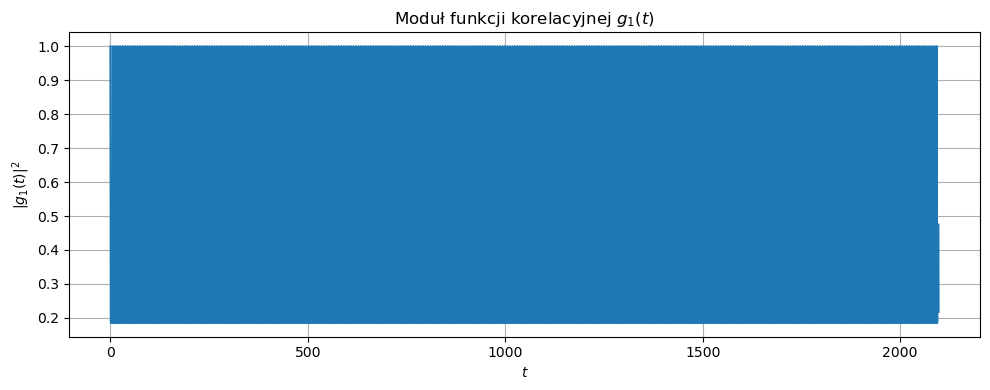

In [30]:
# Wykres
plt.figure(figsize=(10, 4))
plt.plot(t_values, np.abs(g1_t)**2)
plt.xlabel("$t$")
plt.ylabel(r"$|g_1(t)|^2$")
plt.title("Moduł funkcji korelacyjnej $g_1(t)$")
plt.grid(True)
plt.tight_layout()
#plt.xlim(3000,4000)
#plt.ylim(0,0.004)
plt.savefig("Oscylator harmoniczny g(t).pdf", bbox_inches='tight')
plt.show()

In [31]:
start = time.perf_counter()
# Stosuję funkcję okna do g1(t)
window = (1 - np.cos(2 * np.pi * t_values / T_max)) / T_max
#window = np.ones(len(t_values))
g1_windowed = g1_t * window

# Transformata Fouriera z oknem
g1_E = fft(g1_windowed)
freqs = fftfreq(Nt, dt)  # jednostki częstotliwości
E = 2 * np.pi * freqs * ħ  # przekształcenie na energię

# Przesuwam energie i funkcje korelacji
E = np.fft.fftshift(E)
g1_E = np.fft.fftshift(g1_E)
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.023573 sekundy


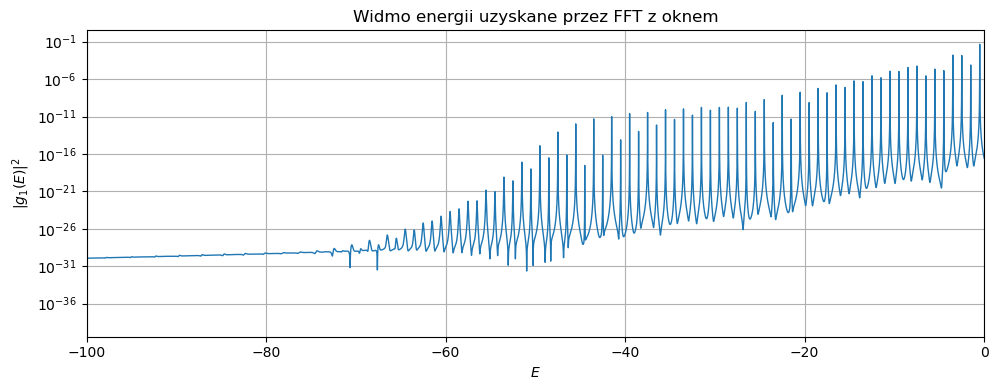

In [32]:
# Wykres widma
plt.figure(figsize=(10, 4))
plt.plot(E, np.abs(g1_E)**2 * 2 / len(g1_E), lw=1)
plt.xlim(-100, 0)
plt.xlabel("$E$")
plt.ylabel(r"$|g_1(E)|^2$")
plt.title("Widmo energii uzyskane przez FFT z oknem")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.savefig("Oscylator harmoniczny g(E) 1.pdf", bbox_inches='tight')
plt.show()

In [13]:
start = time.perf_counter()
# Przepisuję g1_E do zręczniejszej postaci i ustawiam próg dla maksimów
g1_E_temp = (np.abs(g1_E)**2 * 2 / len(g1_E))
threshold = np.max(g1_E_temp) * 0

# Szukam lokalnych maksimów
peak_indices, _ = find_peaks(np.abs(g1_E), height=threshold, prominence=0.0000000001)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 1.174670 sekundy


In [14]:
E[peak_indices]

array([-123.50043371, -121.49906815, -119.50069864, -117.49933308,
       -115.50096358, -113.49959802, -112.49891524, -111.50122852,
       -110.50054574, -109.49986296, -108.49918018, -107.50149346,
       -106.50081068, -105.5001279 , -104.49944512, -103.5017584 ,
       -102.50107562, -101.50039284, -100.49971006,  -99.49902728,
        -98.50134055,  -97.50065777,  -96.49997499,  -95.49929221,
        -94.50160549,  -93.50092271,  -92.50023993,  -91.49955715,
        -90.49887437,  -89.50118765,  -88.50050487,  -87.49982209,
        -86.49913931,  -85.50145259,  -84.50076981,  -83.50008703,
        -82.49940425,  -81.49872147,  -80.50103475,  -79.50035197,
        -78.49966919,  -77.49898641,  -76.50129968,  -75.5006169 ,
        -74.49993412,  -73.49925134,  -72.50156462,  -71.50088184,
        -70.50019906,  -69.49951628,  -68.4988335 ,  -67.50114678,
        -66.500464  ,  -65.49978122,  -64.49909844,  -63.50141172,
        -62.50072894,  -61.50004616,  -60.49936338,  -59.49868

In [ ]:
start = time.perf_counter()

def Gamma1(delta):
    # Funkcja Gamma
    return np.where(np.isclose(delta, 0), 1.0, (np.exp(2j * np.pi * delta) - 1) / (2j * np.pi * delta))

def Phi1(delta):
    # Funkcja Phi
    return Gamma1(delta) - 0.5 * (Gamma1(delta + 1) + Gamma1(delta - 1))

def choosing_delta_prime_from_R(R, T):
    # Funkcja, która wybiera deltę (== przesrunięcie wartości własnej E_n
    # z przyczyny tego, że mamy siatkę tylko z N_t elementów).
    # Korzystam z tej funkcji, bo w artkule Feita, Flecka i Steigera
    # dla wyboru δ' porównujemy R z 1, ale w obliczeniach mamy
    # R zespolone => nie możemy robić operacje < lub > z R.
    # Tu wybór się bazuje na 1) czy |δ'| < 1, 2) chcęmy δ' o mniejszej
    # części urojonej, bo energie są rzeczywistymi, 3) R, które mamy z
    # funkcji korelacji g_1(E), musi być bliskie do Phi(δ') dla
    # odpowiedniej δ'.
    
    # obliczam r = (1+R)/(1-R)
    r = (1 + R) / (1 - R)

    # rozwiązuję równanie kwadratowe δ'^2 - 3 r δ' + 2 = 0
    # δ'_{1,2} = (3r ± sqrt(9 r^2 - 8)) / 2
    discriminant = np.sqrt(9 * r**2 - 8)
    cand1 = (-3 * r + discriminant) / 2
    cand2 = (-3 * r - discriminant) / 2

    candidates = [cand1, cand2]

    # kryteria wyboru:
    best = None
    best_score = None
    for cand in candidates:
        # kryterium 1: czy realna część δ' leży w (-1, 1),
        # bo zakładamy, że jesteśmy blisko E_n
        in_range = np.abs(cand.real) < 1.0

        # kryterium 2: jak duża część urojona δ' (mniejsza => lepiej)
        imag_mag = np.abs(cand.imag)

        # kryterium 3: residual względem rzeczywistego R
        R_model = Phi1(cand + 1) / Phi1(cand - 1)
        residual = np.abs(R_model - R)

        # scoring: najpierw in_range, potem małe imag, potem mały residual
        # im mniejszy score, tym lepiej. Dlatego układamy odpowiednią ważność
        # kryteriów: 1), 3), 2)
        score = (0 if in_range else 1) + 1e-6 * imag_mag + 1e-9 * residual
        
        if (best is None) or (score < best_score):
            best = cand
            best_score = score

    # zwracam najlepsze δ'
    return best

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

In [15]:
start = time.perf_counter()

def compute_En_Wn(E, g1_E, m, T):
    # Funkcja dopasowania z pomocą lineshape fitting
    
    E_m = E[m]

    # zabezpieczenie brzegowe
    if m <= 0 or m >= len(E) - 1:
        return None

    g1_plus = g1_E[m + 1]
    g1_minus = g1_E[m - 1]
    g1_middle = g1_E[m]

    R = g1_plus / g1_minus

    delta_p = choosing_delta_prime_from_R(R, T)
    
#    r = (1 + R) / (1 - R)
#    discriminant = 9 * r**2 - 8
#    if np.real(discriminant) < 0:
#        return None  # nie ma pierwiastka rzeczywistego, pomijam

#    sqrt_term = np.sqrt(discriminant)

    
    
#    if np.abs(R) < 1:
#        delta_p = (-3 * r + sqrt_term) / 2
#    else:
#        delta_p = (-3 * r - sqrt_term) / 2

    E_n = E_m - (2 * np.pi * delta_p) / T
    phi = Phi1(delta_p)
    W_n = g1_middle / phi

    return E_n, W_n, delta_p, R

# Lista wyników
results = []

for m in peak_indices:
    res = compute_En_Wn(E, g1_E, m, T_max)
    if res is not None:
        E_n, W_n, delta_p, R = res
        results.append({
            'E_n': E_n.real,
            'W_n_abs': np.abs(W_n),
            'W_n_phase': np.angle(W_n),
            'delta_p': delta_p,
            'R': R
        })

# Sortowanie według energii

#results = [r for r in results if r['E_n'] >= -5]
for r in results: r['E_n'] *= -1
    
results.sort(key=lambda x: x['E_n'])

# Wyświetlenie wyników
print(f"{'E_n [a.u.]':>12} | {'|W_n|':>12} | {'arg(W_n) [rad]':>14} | {'δ′':>8}")
print(" " + "-" * 66)
for r in results:
    print(f"{(r['E_n']):12.6f} | {r['W_n_abs']:12.6e} | {r['W_n_phase']:14.6f} | {r['delta_p'].real:8.3f}")

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

  E_n [a.u.] |        |W_n| | arg(W_n) [rad] |       δ′
 ------------------------------------------------------------------
    0.500681 | 7.769665e+01 |      -0.004000 |    0.114
    1.502044 | 3.395064e+00 |      -0.012000 |    0.341
    2.497415 | 1.543328e+01 |      -0.020000 |   -0.432
    3.498778 | 1.497318e+01 |      -0.028000 |   -0.205
    4.500141 | 1.332186e+00 |      -0.036000 |    0.022
    5.501504 | 1.746253e+00 |      -0.044000 |    0.249
    6.502867 | 6.863608e-01 |      -0.052000 |    0.476
    7.498237 | 2.870062e+00 |      -0.060000 |   -0.297
    8.499600 | 2.144534e+00 |      -0.068000 |   -0.070
    9.500963 | 1.170577e+00 |      -0.076000 |    0.157
   10.502326 | 1.346329e+00 |      -0.084000 |    0.384
   11.497697 | 4.899326e-01 |      -0.092000 |   -0.389
   12.499060 | 6.126425e-01 |      -0.100000 |   -0.162
   13.500423 | 2.444087e-01 |      -0.108000 |    0.065
   14.501786 | 2.896929e-01 |      -0.116000 |    0.292
   15.497156 | 1.165625e-01 |      -

In [16]:
len(results)

119

In [17]:
energies = np.array([r["E_n"] for r in results])

In [18]:
np.save("energie własne E dla oscylatora harmonicznego 1D SM.npy", energies)

In [19]:
start = time.perf_counter()
# Stosujemy okno czasowe Hann jak wcześniej
psi_t_windowed = psi_t * window[:, np.newaxis]

# FFT po czasie, dla każdego x
psi_E = fft(psi_t_windowed, axis=0)  # shape: (Nt, Nx)

psi_E = np.fft.fftshift(psi_E, axes=0)  # Przesunięcie zerowej częstotliwości na środek

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 6.905269 sekundy


In [20]:
start = time.perf_counter()
eigen_psi = []

for r in results:
    # Znajduję najbliższy indeks na osi energii
    idx = np.argmin(np.abs(E + r['E_n']))
    psi_n = psi_E[idx, :]  # Funkcja falowa dla En (do normowania)
    eigen_psi.append(psi_n)

end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.204916 sekundy


In [21]:
start = time.perf_counter()
eigen_psi_norm = [ψn / np.linalg.norm(ψn) for ψn in eigen_psi]
end = time.perf_counter()
print(f"Czas działania: {end - start:.6f} sekundy")

Czas działania: 0.002384 sekundy


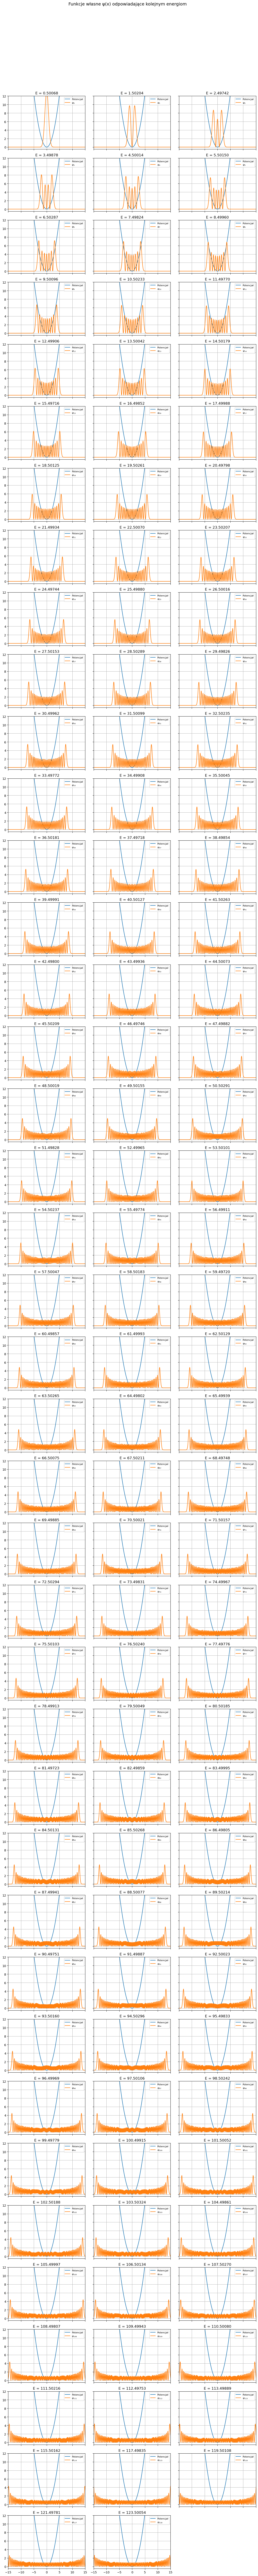

In [22]:
num_states = len(eigen_psi_norm)
cols = 3
rows = (num_states + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()

for i, ψn in enumerate(eigen_psi_norm):
    ax = axes[i]
    ax.plot(x, V, label = "Potencjał")
    ax.plot(x, 300*np.abs(ψn)**2, label=r"$\psi_{%d}$" % i)
    ax.set_title(f"E = {(results[i]['E_n']):.5f}")
    ax.grid(True)
    ax.legend(fontsize=8)
    ax.set_xlim(-15, 15)
    ax.set_ylim(-0.5, 12)

# Jeśli są puste komórki, wyłącz je
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Funkcje własne ψ(x) odpowiadające kolejnym energiom", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [135]:
np.save("funkcje psi(E) dla oscylatora harmonicznego 1D SM.npy", eigen_psi_norm)

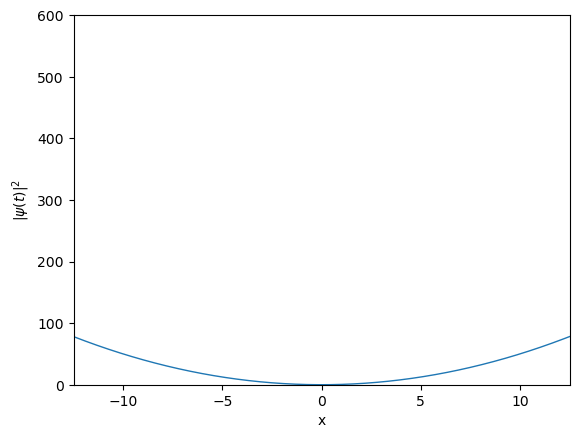

In [138]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

line_V, = ax.plot(x, V, lw=1,  label="V(x)")
line, = ax.plot([], [], lw=2)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 600)

ax.set_xlabel("x")
ax.set_ylabel("$|ψ(t)|^2$")
plt.show()

def init():
    line.set_data([], [])
    return line,

def update(frame):
    y = 5000*np.abs(psi_t[frame])**2
    line.set_data(x, y)
    ax.set_title(f"t = {t_values[frame]:.2f}")
    return line,

ani = animation.FuncAnimation(fig, update, frames = range(0, Nt // 2**4, 10), init_func=init, blit=True)

In [139]:
# Robię filmik ewolucji funkcji w czasie

from matplotlib.animation import FFMpegWriter
import matplotlib as mpl

mpl.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=2800)
ani.save("Oscylator harmoniczny.mp4", writer=writer)